## Load packages

### Install custom packages from Github

In [1]:
pip install git+https://github.com/GeoscienceAustralia/dea-intertidal.git --quiet

In [2]:
pip install git+https://github.com/digitalearthafrica/deafrica-coastlines.git --quiet

In [3]:
cd ..

/home/jovyan/Robbi/dea-intertidal


In [4]:
import pandas as pd

import datacube
import odc.geo.xr

from coastlines.raster import model_tides
from intertidal.extents import pixel_tides

dc = datacube.Datacube()

## Model tides using FES2014 for x, y, times

In [5]:
tide_df = model_tides(
    x=[140.66],
    y=[-17.14],
    time=pd.date_range(start="1987", end="2018", freq="2H"),
    model="FES2014",
    directory="~/tide_models_clipped",
)

tide_df

,x,y,tide_m
time,,,
1987-01-01 00:00:00,140.66,-17.14,-1.821712
1987-01-01 02:00:00,140.66,-17.14,-1.220672
1987-01-01 04:00:00,140.66,-17.14,-0.229443
1987-01-01 06:00:00,140.66,-17.14,0.891527
1987-01-01 08:00:00,140.66,-17.14,1.795503
...,...,...,...
2017-12-31 16:00:00,140.66,-17.14,-0.213535
2017-12-31 18:00:00,140.66,-17.14,-0.654301
2017-12-31 20:00:00,140.66,-17.14,-1.042705


<AxesSubplot:xlabel='time'>

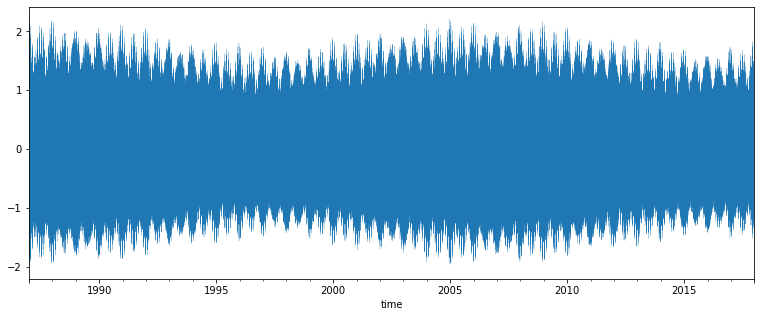

In [6]:
tide_df.tide_m.plot(lw=0.2, figsize=(13, 5))

## Model pixel-based tides using FES2014 into spatial grid of a dataset

## Load some data

In [7]:
ds = dc.load(
    product="ga_ls8c_ard_3",
    x=(136.690313, 137.047967),
    y=(-15.790806, -15.983754), 
    time=("2022-01", "2022-01"),
    output_crs="EPSG:3577",
    resolution=(-10, 10),
    measurements=["nbart_red"],
)
ds

<xarray.Dataset>
Dimensions:      (time: 4, y: 2269, x: 3932)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-03T00:53:20.389457 ... 2022-01...
  * y            (y) float64 -1.688e+06 -1.688e+06 ... -1.71e+06 -1.71e+06
  * x            (x) float64 5.048e+05 5.048e+05 ... 5.441e+05 5.441e+05
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) int16 8217 8222 8222 8222 ... -999 -999 -999 -999
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

By default, the function will model tides into a low res grid (500 * cell size = 5000 m resolution) surrounding the input dataset. The lower res data includes a buffer around the extent of `ds` so that tides can be modelled seamlessly across analysis boundaries.

In [8]:
tides_lowres = pixel_tides(ds,
                           model="FES2014",
                           directory="~/tide_models_clipped")

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Returning low resolution tide array


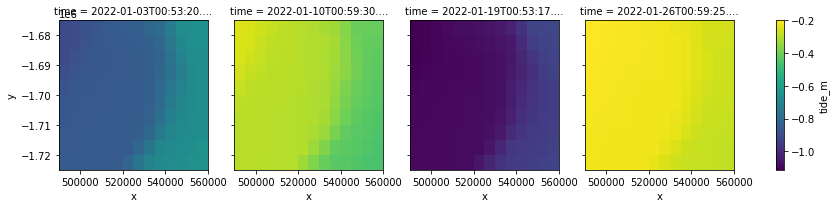

In [9]:
tides_lowres.plot.imshow(col='time')

### Reprojecting back into original high resolution spatial grid
By providing a resampling function, we can also re-project the low res data back to the spatial extent and resolution of the input `ds` dataset:

In [10]:
def _reproject(x, to_geobox=ds.odc.geobox):
    return x.odc.reproject(to_geobox, resampling="bilinear")

tides_highres, tides_lowres = pixel_tides(ds, 
                                          resample_func=_reproject, 
                                          model="FES2014", 
                                          directory="~/tide_models_clipped")

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


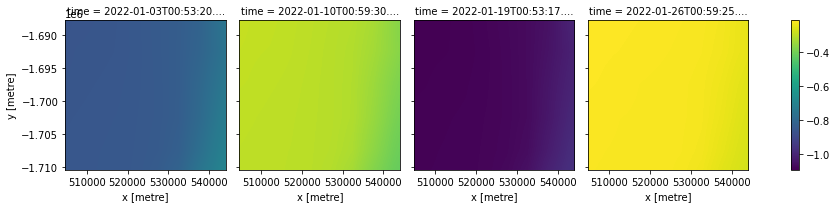

In [11]:
tides_highres.plot.imshow(col='time')

`tides_highres` will have the same dimensions as `ds`:

In [12]:
ds.sizes

Frozen({'time': 4, 'y': 2269, 'x': 3932})

In [13]:
tides_highres.sizes

Frozen({'time': 4, 'y': 2269, 'x': 3932})

So it can be added as an additional 3D variable in the data:

In [14]:
ds['tide_m'] = tides_highres
ds

<xarray.Dataset>
Dimensions:      (time: 4, y: 2269, x: 3932)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-03T00:53:20.389457 ... 2022-01...
  * y            (y) float64 -1.688e+06 -1.688e+06 ... -1.71e+06 -1.71e+06
  * x            (x) float64 5.048e+05 5.048e+05 ... 5.441e+05 5.441e+05
    spatial_ref  int32 3577
Data variables:
    nbart_red    (time, y, x) int16 8217 8222 8222 8222 ... -999 -999 -999 -999
    tide_m       (time, y, x) float32 -0.8673 -0.8672 ... -0.2695 -0.2695
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

## Other possibly useful functionality

#### Calculating min/max/quantiles of tide heights:
Calculating min and max tide across all observations by passing in a list of quantiles/percentiles. This is done on the low resolution data before reprojecting to higher resolution, so should be faster than calculating min/max tide after reprojecting.

In [15]:
tides_highres_quantiles, tides_lowres_quantiles = pixel_tides(
    ds, resample_func=_reproject, calculate_quantiles=[0.0, 1.0], model="FES2014", directory="~/tide_models_clipped"
)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


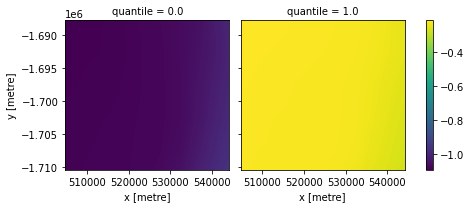

In [16]:
tides_highres_quantiles.plot.imshow(col='quantile')

### Custom times:
Calculating tides for a custom set of times intead of the `time` dimension on the input dataset:

In [17]:
custom_times = pd.date_range(start="2022-01-01", end="2022-01-02", freq="6H")

tides_highres, tides_lowres = pixel_tides(ds, 
                                          resample_func=_reproject, 
                                          times=custom_times,
                                          model="FES2014", 
                                          directory="~/tide_models_clipped")

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 5/5 [00:01<00:00,  4.01it/s]


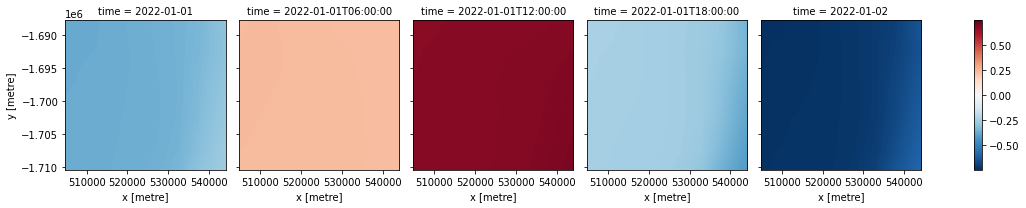

In [18]:
tides_highres.plot.imshow(col='time')